In [153]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.
import kagglehub
amananandrai_ag_news_classification_dataset_path = kagglehub.dataset_download('amananandrai/ag-news-classification-dataset')

amananandrai_ag_news_classification_dataset_path

'/root/.cache/kagglehub/datasets/amananandrai/ag-news-classification-dataset/versions/2'

In [154]:
import pandas as pd
import numpy as np
import seaborn as sns
import re

from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report

In [155]:
train_df = pd.read_csv(amananandrai_ag_news_classification_dataset_path+'/train.csv')
test_df = pd.read_csv(amananandrai_ag_news_classification_dataset_path+'/test.csv')

### Смотрим на данные

In [156]:
train_df.head()

,Class Index,Title,Description
0,3,Wall St. Bears Claw Back Into the Black (Reuters),"Reuters - Short-sellers, Wall Street's dwindli..."
1,3,Carlyle Looks Toward Commercial Aerospace (Reu...,Reuters - Private investment firm Carlyle Grou...
2,3,Oil and Economy Cloud Stocks' Outlook (Reuters),Reuters - Soaring crude prices plus worries\ab...
3,3,Iraq Halts Oil Exports from Main Southern Pipe...,Reuters - Authorities have halted oil export\f...
4,3,"Oil prices soar to all-time record, posing new...","AFP - Tearaway world oil prices, toppling reco..."


In [157]:
test_df.head()

,Class Index,Title,Description
0,3,Fears for T N pension after talks,Unions representing workers at Turner Newall...
1,4,The Race is On: Second Private Team Sets Launc...,"SPACE.com - TORONTO, Canada -- A second\team o..."
2,4,Ky. Company Wins Grant to Study Peptides (AP),AP - A company founded by a chemistry research...
3,4,Prediction Unit Helps Forecast Wildfires (AP),AP - It's barely dawn when Mike Fitzpatrick st...
4,4,Calif. Aims to Limit Farm-Related Smog (AP),AP - Southern California's smog-fighting agenc...


In [158]:
df = pd.concat([train_df, test_df], ignore_index=True)

In [159]:
df.tail()

,Class Index,Title,Description
127595,1,Around the world,Ukrainian presidential candidate Viktor Yushch...
127596,2,Void is filled with Clement,With the supply of attractive pitching options...
127597,2,Martinez leaves bitter,Like Roger Clemens did almost exactly eight ye...
127598,3,5 of arthritis patients in Singapore take Bext...,SINGAPORE : Doctors in the United States have ...
127599,3,EBay gets into rentals,EBay plans to buy the apartment and home renta...


In [160]:
df.describe()

,Class Index
count,127600.000000
mean,2.500000
std,1.118038
min,1.000000
25%,1.750000
50%,2.500000
75%,3.250000
max,4.000000


<Axes: xlabel='Class Index', ylabel='Count'>

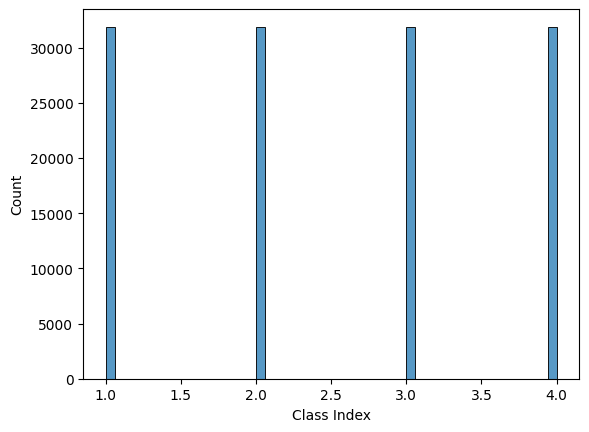

In [161]:
sns.histplot(data=df, x='Class Index')

In [162]:
df.groupby('Class Index').aggregate({'Class Index': 'count'})

,Class Index
Class Index,
1,31900
2,31900
3,31900
4,31900


In [163]:
df.groupby('Title').aggregate({'Title': 'count'})

,Title
Title,
#147;Generic Superheroes #148;,1
#36;1.3M Plan Aims to Save Calif. State Fish (AP),1
#36;11.6B Bill for Athens Games May Climb (AP),1
#36;12 Million Fine Against Cingular Upheld (Reuters),1
#36;1B in Federal Aid to Schools Delayed (AP),1
...,...
weather wrecks a classic,1
webcrawler : Internet2 is coming,1
webcrawler: A9.com is cool,1


Почти все заголовки

### Объединяем заголовок и описание

In [164]:
df['text'] = df['Title'] + ' ' + df['Description']  # Объединяем заголовок и описание

### Предобработка текста

In [165]:
from nltk import download
download('stopwords')
download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [166]:
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

In [167]:
def preprocess_text(text):
    # Удаление специальных символов и чисел
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    # Приведение к нижнему регистру
    text = text.lower()
    # Удаление стоп-слов и лемматизация
    tokens = text.split()
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]
    return ' '.join(tokens)


In [168]:
# Применяем предобработку к тексту
df['processed_text'] = df['text'].apply(preprocess_text)

In [169]:
# Разделение данных на обучающую и тестовую выборки
X = df['processed_text']
y = df['Class Index']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [170]:
vectorizer = TfidfVectorizer(max_features=5000)  # Ограничиваемся 5000 признаками для скорости

In [171]:
# Векторизация текста (TF-IDF)
X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec = vectorizer.transform(X_test)

# Обучение модели
model = LogisticRegression(max_iter=1000)  # Увеличиваем max_iter для сходимости
model.fit(X_train_vec, y_train)

LogisticRegression(max_iter=1000)

In [172]:
# Предсказание и оценка
y_pred = model.predict(X_test_vec)
print(f"Accuracy: {accuracy_score(y_test, y_pred):.2f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred))


Accuracy: 0.91

Classification Report:
              precision    recall  f1-score   support

           1       0.92      0.89      0.90      6283
           2       0.95      0.98      0.96      6466
           3       0.88      0.88      0.88      6370
           4       0.89      0.88      0.89      6401

    accuracy                           0.91     25520
   macro avg       0.91      0.91      0.91     25520
weighted avg       0.91      0.91      0.91     25520



In [173]:
class_num_to_title = {1: "World", 2: "Sports", 3: "Business", 4: "Sci/Tech"}

def predict_label(texts):
  # sample_text = ["Microsoft announces new AI-powered features for Windows 11."]
  texts_df = pd.DataFrame(texts, columns=['text'])
  texts_df['text'] = texts_df['text'].apply(preprocess_text)
  sample_vec = vectorizer.transform(texts_df['text'])
  predicted_label_num = model.predict(sample_vec)
  texts_df['class_predicted'] = pd.Series(predicted_label_num)
  texts_df['class_predicted'] = texts_df['class_predicted'].replace(class_num_to_title)
  return texts_df

In [174]:
to_predict = ['Microsoft announces new AI-powered features for Windows 11.', "Cristiano Ronaldo shares top scores at football"]
predict_label(to_predict)

,text,class_predicted
0,microsoft announces new aipowered feature window,Sci/Tech
1,cristiano ronaldo share top score football,Sports
